# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [3]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [16]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [17]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [18]:
df_reviews.sample(10)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
33962,tt0405422,movie,The 40-Year-Old Virgin,The 40 Year Old Virgin,2005,\N,116,0,"Comedy,Romance",7.1,383366,As we all know the sub-genre of sex comedies i...,9,pos,1,train,1753
37606,tt0446345,movie,The Ground Truth,The Ground Truth: After the Killing Ends,2006,\N,72,0,"Documentary,War",7.5,711,"This picture seemed way to slanted, it's almos...",1,neg,0,train,984
39788,tt0478706,movie,The Milkwoman,Itsuka dokusho suruhi,2005,\N,127,0,"Drama,Romance",6.9,113,I guess those who have been in a one-sided rel...,7,pos,1,test,10244
984,tt0063308,movie,"A Minute to Pray, a Second to Die","Un minuto per pregare, un istante per morire",1968,\N,118,0,"Action,Crime,Drama",6.4,419,The cast alone tells you this will be a notch ...,7,pos,1,test,7816
37615,tt0446345,movie,The Ground Truth,The Ground Truth: After the Killing Ends,2006,\N,72,0,"Documentary,War",7.5,711,This shorter movie is the epitome the expected...,10,pos,1,train,3421
33900,tt0040869,movie,That Lady in Ermine,That Lady in Ermine,1948,\N,89,0,"Comedy,Fantasy,Musical",5.9,627,Can I be as simple and primitive in my evaluat...,8,pos,1,train,5842
46949,tt0032155,movie,Young Mr. Lincoln,Young Mr. Lincoln,1939,\N,100,0,"Biography,Drama,History",7.6,7192,This film was not only one of John Ford's own ...,9,pos,1,train,3940
28815,tt0257044,movie,Road to Perdition,Road to Perdition,2002,\N,117,0,"Crime,Drama,Thriller",7.7,240986,Conrad Hall went out with a bang. The great fi...,9,pos,1,train,9530
36855,tt0109770,movie,The Fantastic Four,The Fantastic Four,1994,\N,90,0,"Action,Adventure,Family",3.8,4828,"When HULK hit theaters in 2003, it wasn't long...",4,neg,0,test,9875
39525,tt0044876,movie,The Man in the White Suit,The Man in the White Suit,1951,\N,85,0,"Comedy,Drama,Sci-Fi",7.3,8586,While Hollywood got sort of stagnant during th...,10,pos,1,train,9405


In [19]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [20]:
df_reviews[df_reviews['average_rating'].isna()].head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


OK, we see one movie with unknown average rating and votes, since it is only 2 rows and 2 nan values we can drop them off, so we will have a clear dataset.

In [21]:
df_reviews = df_reviews.dropna(subset=['average_rating'])

In [22]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47329 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47329 non-null  object 
 1   title_type       47329 non-null  object 
 2   primary_title    47329 non-null  object 
 3   original_title   47329 non-null  object 
 4   start_year       47329 non-null  int64  
 5   end_year         47329 non-null  object 
 6   runtime_minutes  47329 non-null  object 
 7   is_adult         47329 non-null  int64  
 8   genres           47329 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47329 non-null  object 
 12  rating           47329 non-null  int64  
 13  sp               47329 non-null  object 
 14  pos              47329 non-null  int64  
 15  ds_part          47329 non-null  object 
 16  idx              47329 non-null  int64  
dtypes: Int64(1),

In [23]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47329.000000,47329.000000,47329.000000,4.732900e+04,47329.000000,47329.000000,47329.000000
mean,1989.630882,0.001733,5.998278,2.556292e+04,5.484439,0.498933,6279.826808
std,19.600702,0.041588,1.494289,8.367004e+04,3.473083,0.500004,3605.724280
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6300.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


In [24]:
print('Duplicates amount:',df_reviews.duplicated().value_counts())

Duplicates amount: False    47329
dtype: int64


After examine the dataset we can see that the dataset had 2 missing values, I dropped them, has no duplicates and anomalies.

## EDA

Let's check the number of movies and reviews over years.

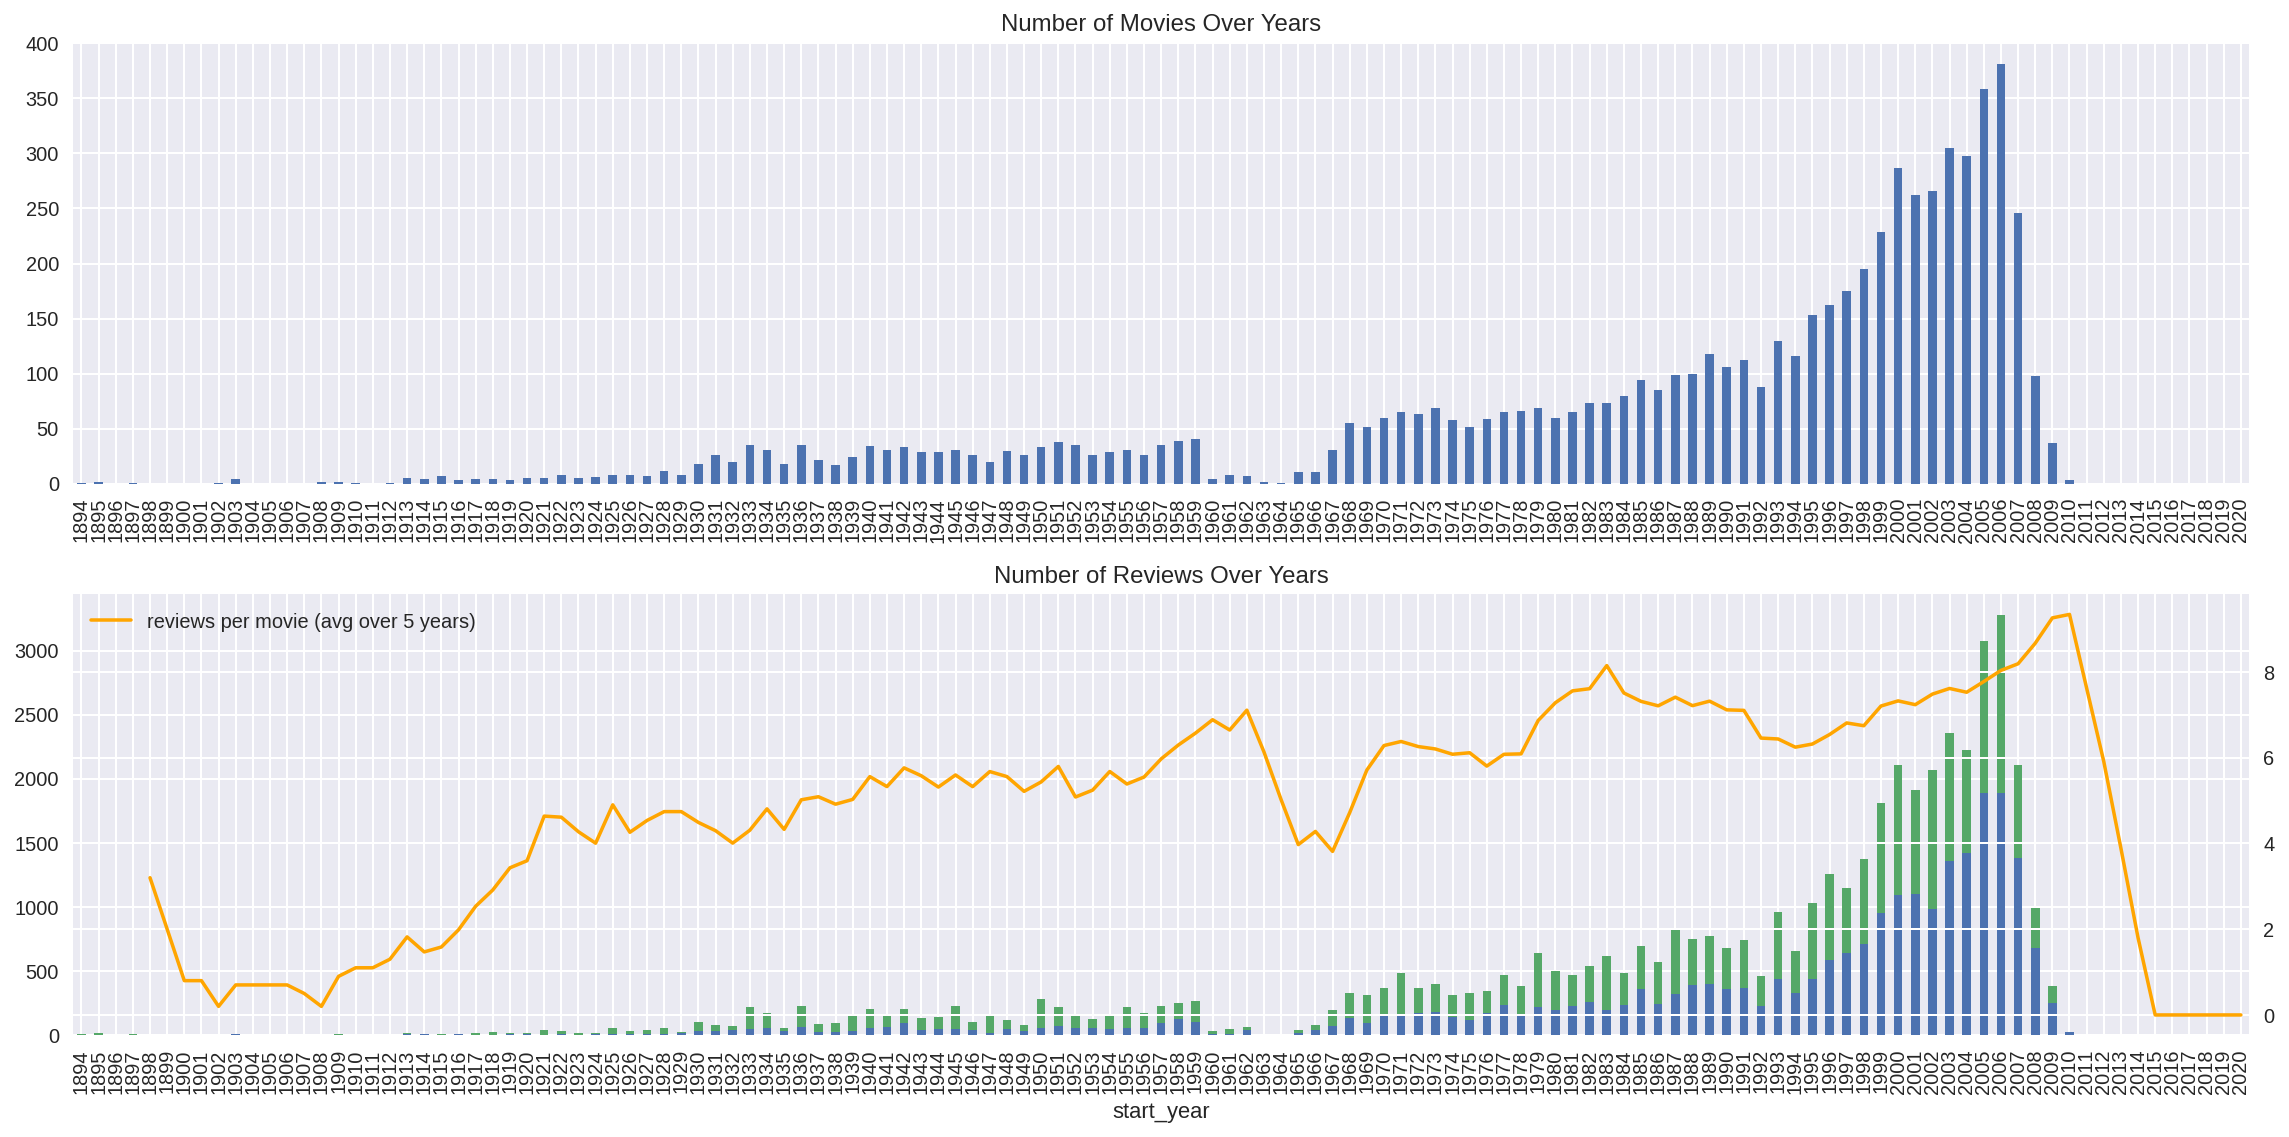

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

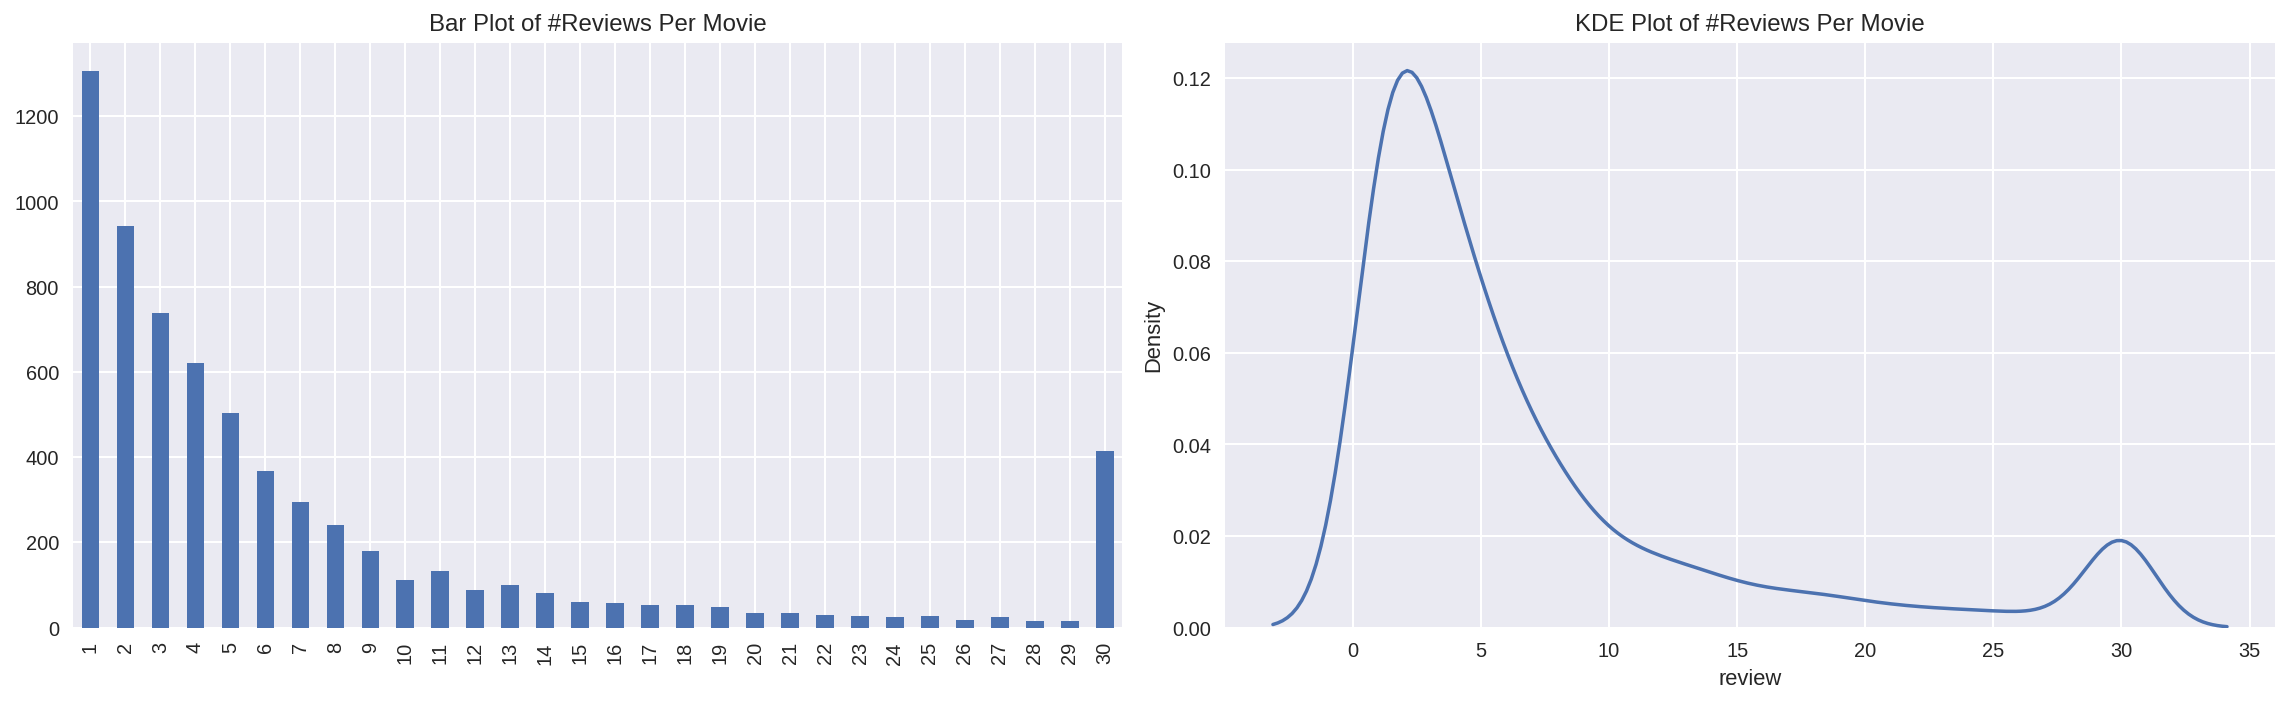

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

As we can see the numer of reviews is increasing year by year. It can be connected with appearing of internet and new opportunites to show your opinion there.

In [27]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

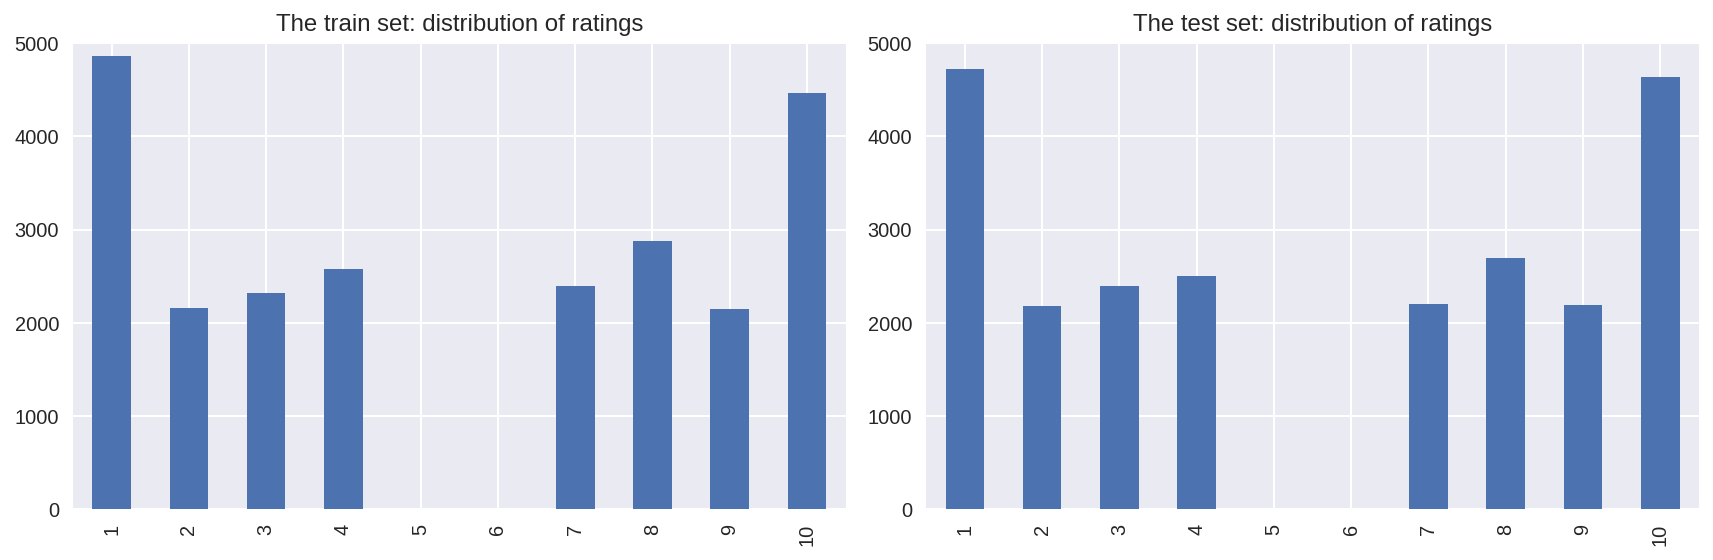

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

We can see that our data is balanced.

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


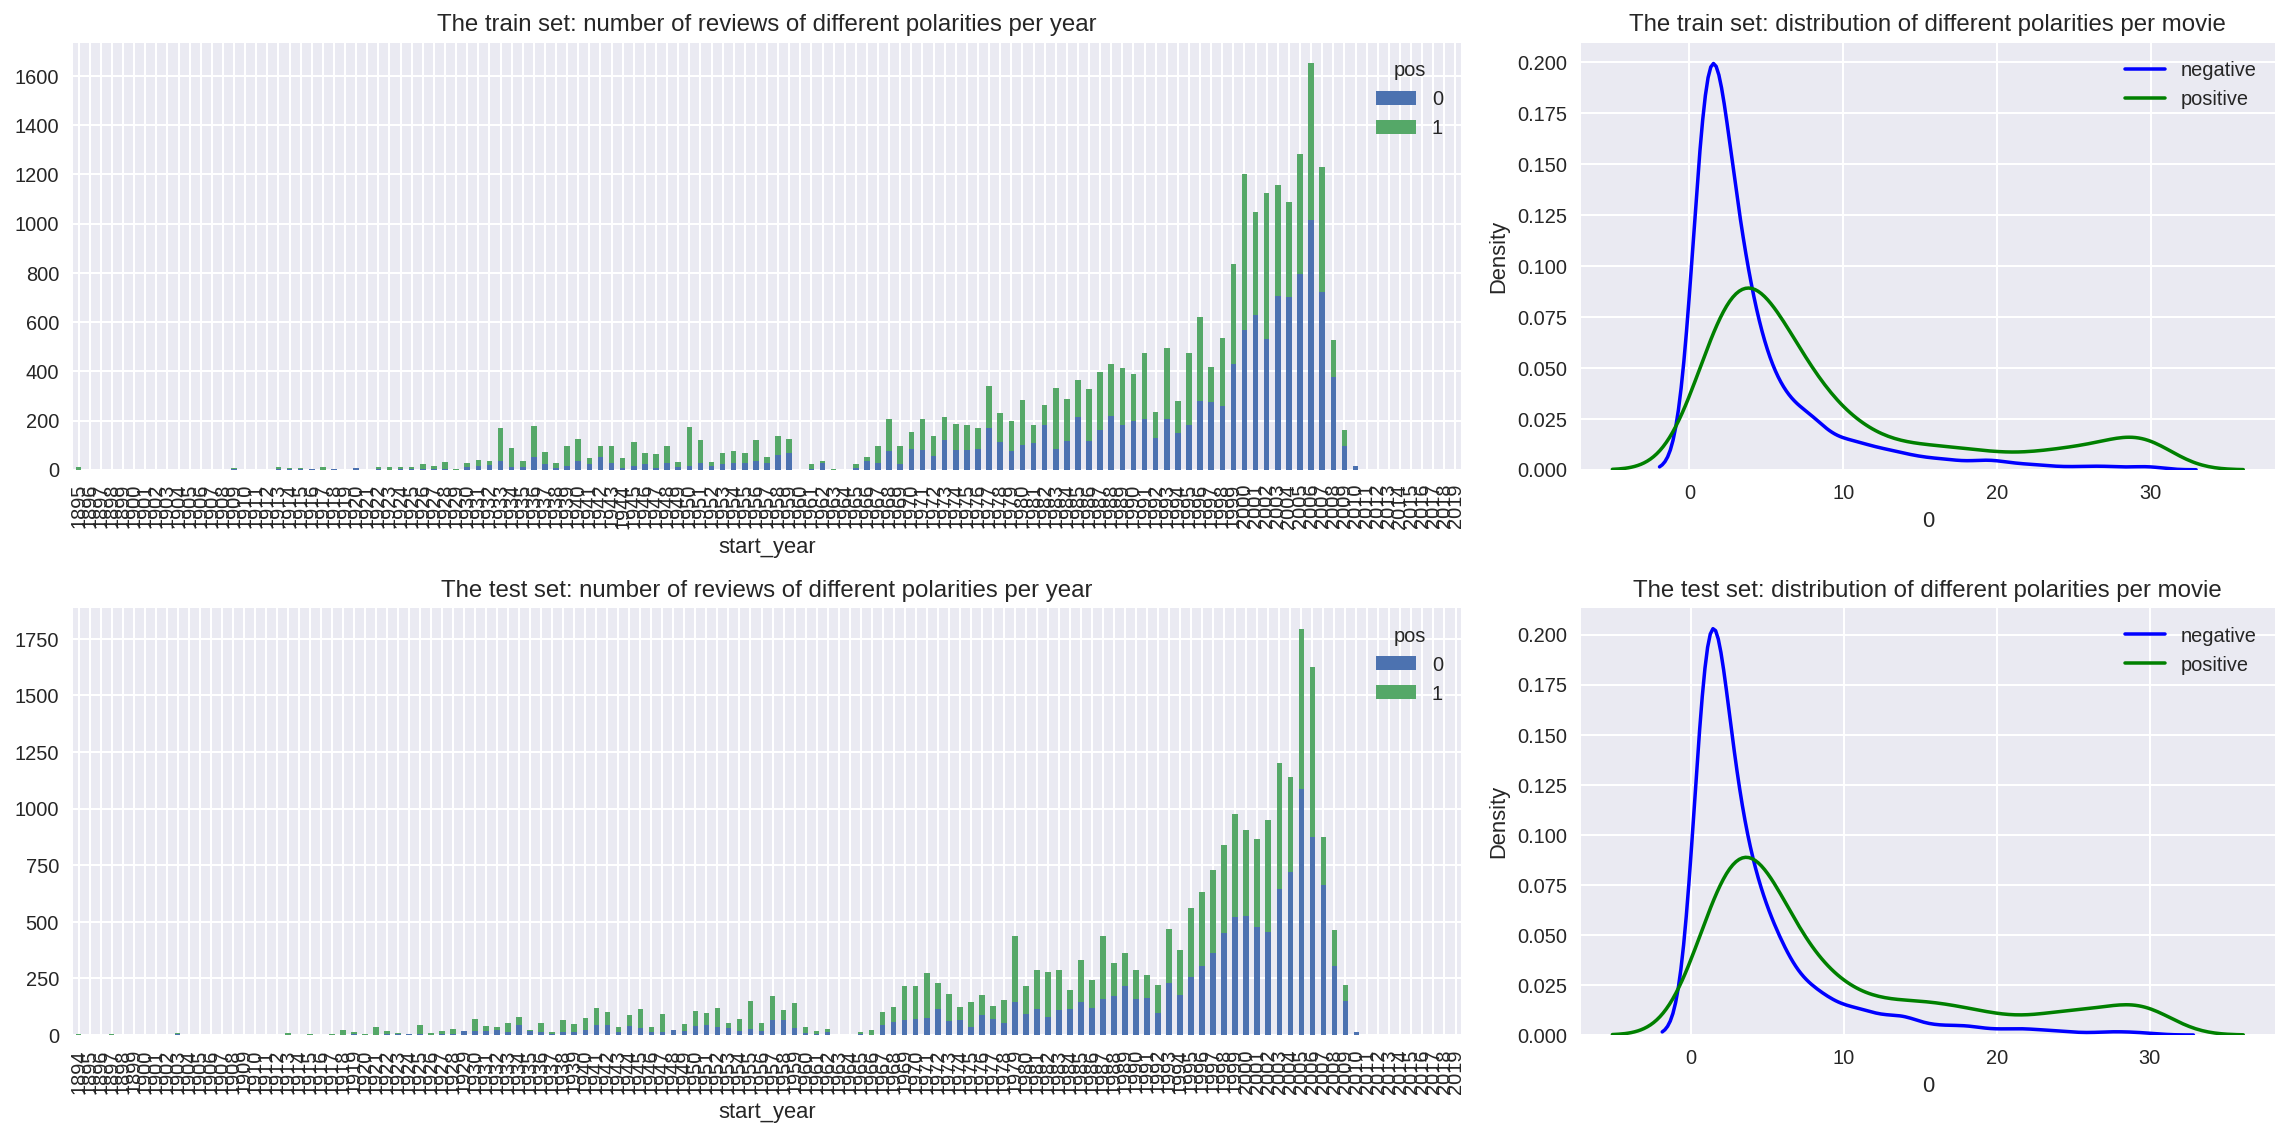

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

As we can see there is no disbalance in our datasets, they are ready for further work

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [30]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [31]:
import re

In [32]:
df_reviews['review_norm'] = df_reviews['review'].apply(lambda x: " ".join(re.sub(r'[^a-zA-Z\']', ' ', x.lower()).split()))

In [33]:
df_reviews.loc[1,'review']

'How the hell did they get this made?! Presenting itself as a caper comedy, the misbegotten "$" is essentially two hours of people mumbling sentence fragments. The usually dependable Warren Beatty looks drunk, and the usually hilarious Goldie Hawn acts like she\'s on depressants. As for Gert Frobe, his most famous role - Goldfinger - was infinitely more admirable than his character here. Not even the guy with the champagne bottle of LSD can save this litany of worthlessness. Am I comparing this movie to "Plan 9 from Outer Space"? I wouldn\'t do such a thing even if someone paid me. "P9FOS" was idiotically made but ended up hilarious; this was idiotically made and causes you to feel like your brain just melted out of your ears. Warren Beatty and Goldie Hawn made up for this when they co-starred in "Shampoo", but then they co-starred in the dreadful "Town & Country". Maybe they just shouldn\'t co-star in movies. All in all, I would rather have my skin torn off than have to watch this aga

In [34]:
df_reviews.loc[1,'review_norm']

"how the hell did they get this made presenting itself as a caper comedy the misbegotten is essentially two hours of people mumbling sentence fragments the usually dependable warren beatty looks drunk and the usually hilarious goldie hawn acts like she's on depressants as for gert frobe his most famous role goldfinger was infinitely more admirable than his character here not even the guy with the champagne bottle of lsd can save this litany of worthlessness am i comparing this movie to plan from outer space i wouldn't do such a thing even if someone paid me p fos was idiotically made but ended up hilarious this was idiotically made and causes you to feel like your brain just melted out of your ears warren beatty and goldie hawn made up for this when they co starred in shampoo but then they co starred in the dreadful town country maybe they just shouldn't co star in movies all in all i would rather have my skin torn off than have to watch this again awful maybe they should remake it wit

Ok, we normilized the text for the further work

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [35]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


## Working with models

### Model 0 - Constant

In [7]:
from sklearn.dummy import DummyClassifier

In [24]:
train_features_0 = df_reviews_train['review_norm']
test_features_0 = df_reviews_test['review_norm']

In [25]:
model_0 = DummyClassifier(strategy= 'stratified', random_state = 123)

In [26]:
%%time
model_0.fit(train_features_0, train_target)

CPU times: user 0 ns, sys: 1.45 ms, total: 1.45 ms
Wall time: 1.19 ms


DummyClassifier(random_state=123, strategy='stratified')

          train  test
Accuracy    0.5   0.5
F1          0.5   0.5
APS         0.5   0.5
ROC AUC     0.5   0.5


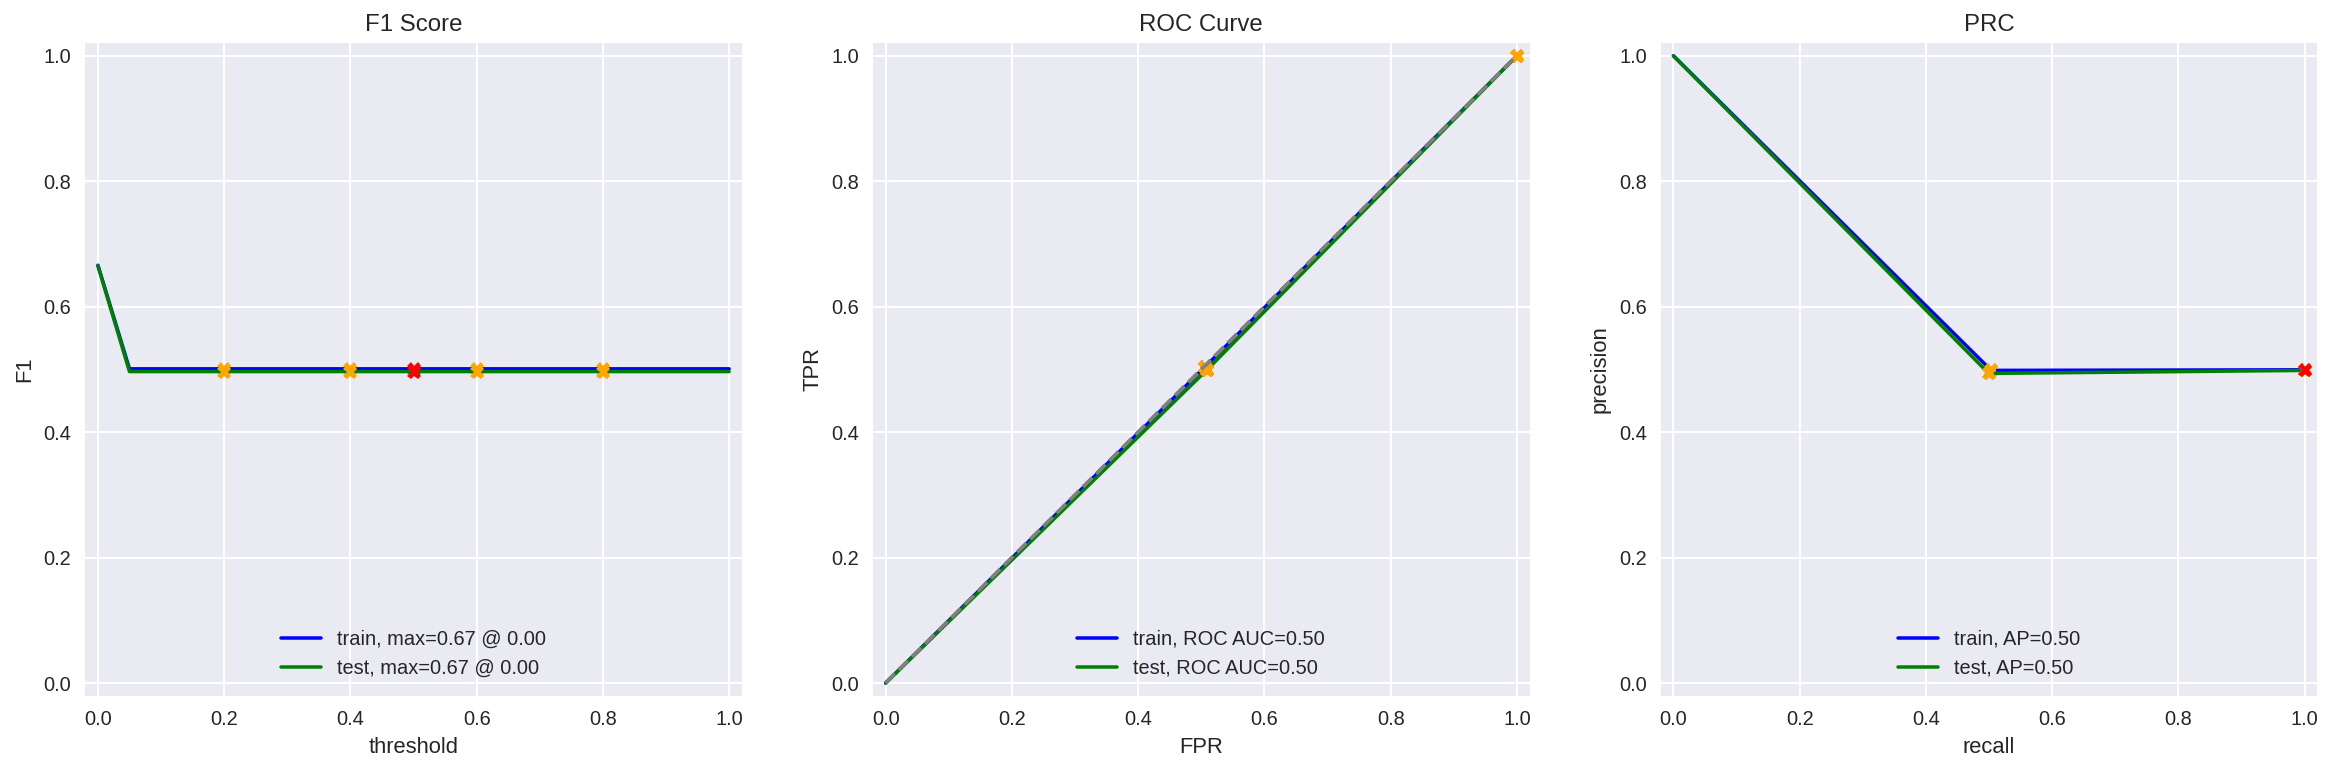

In [27]:
evaluate_model(model_0, train_features_0, train_target, test_features_0, test_target)

We have a balanced target so our dummy model has 50/50 prediction.

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [63]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline

In [36]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [37]:
def text_preprocessing_1(text):
    tokens = word_tokenize(text)
    lemmas = [WordNetLemmatizer().lemmatize(token) for token in tokens]
    
    return " ".join(lemmas)

In [42]:
%%time
corpus_train_1 = df_reviews_train['review_norm'].apply(text_preprocessing_1)
corpus_test_1 = df_reviews_test['review_norm'].apply(text_preprocessing_1)

CPU times: user 1min 10s, sys: 365 ms, total: 1min 10s
Wall time: 1min 10s


In [43]:
from sklearn.model_selection import GridSearchCV

In [44]:
stop_words = set(stopwords.words('english'))
model_1 = Pipeline(
    steps=[("tfidf", TfidfVectorizer(stop_words=stop_words)), 
           ("clf", LogisticRegression(random_state = 123))]
)

param_grid = {'clf__C': [0.1, 1, 10, 100]}
grid1 = GridSearchCV(model_1, param_grid, cv=3, scoring = "f1")

grid1.fit(corpus_train_1, train_target)

print("Best params:")
print(grid1.best_params_)

print(f"Best F1 score: {abs(grid1.best_score_):.3f}")

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Best params:
{'clf__C': 1}
Best F1 score: 0.870


In [45]:
%%time
model_1 = Pipeline(
    steps=[("tfidf", TfidfVectorizer(stop_words=stop_words)), 
           ("clf", LogisticRegression(C = 1, random_state = 123))]
)

model_1.fit(corpus_train_1, train_target)

CPU times: user 7.64 s, sys: 8.49 s, total: 16.1 s
Wall time: 16.1 s


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('clf', LogisticRegression(C=1, random_state=123))])

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


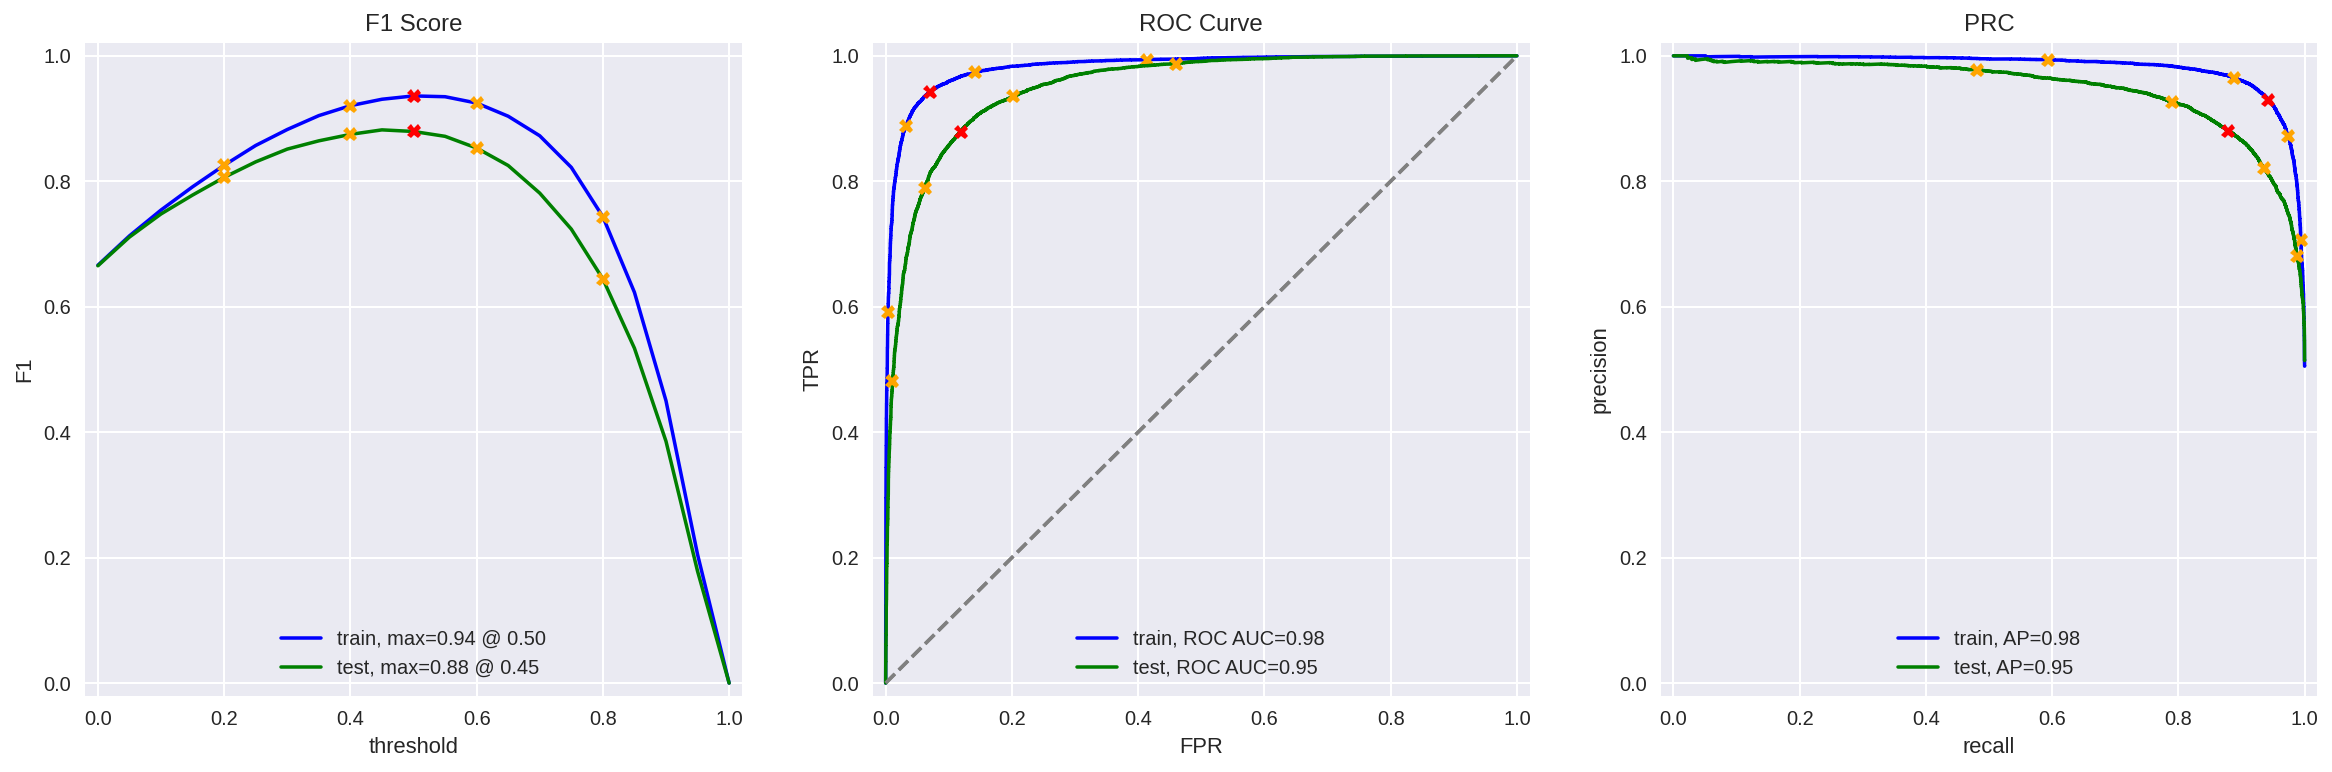

In [46]:
evaluate_model(model_1, corpus_train_1, train_target, corpus_test_1, test_target)

With TF-IDF and LR we got F1 score 0.94 for train set and 0.88 for test set which is fits our task where F1 should be at least 0.85.

### Model 3 - spaCy, TF-IDF and LR

In [9]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [47]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [48]:
%%time
corpus_train_3 = df_reviews_train['review_norm'].apply(text_preprocessing_3)
corpus_test_3 = df_reviews_test['review_norm'].apply(text_preprocessing_3)

CPU times: user 10min 49s, sys: 0 ns, total: 10min 49s
Wall time: 10min 50s


In [49]:
model_3 = Pipeline(
    steps=[("tfidf", TfidfVectorizer(stop_words=stop_words)), 
           ("clf", LogisticRegression(random_state = 123))]
)

param_grid = {'clf__C': [0.1, 1, 10, 100]}
grid3 = GridSearchCV(model_3, param_grid, cv=3, scoring = "f1")

grid3.fit(corpus_train_3, train_target)

print("Best params:")
print(grid3.best_params_)

print(f"Best F1 score: {abs(grid3.best_score_):.3f}")

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Best params:
{'clf__C': 1}
Best F1 score: 0.867


In [52]:
%%time
model_3 = Pipeline(
    steps=[("tfidf", TfidfVectorizer(stop_words=stop_words)), 
           ("clf", LogisticRegression(C = 1, random_state = 123))]
)

model_3.fit(corpus_train_3, train_target)

CPU times: user 5.64 s, sys: 4.6 s, total: 10.2 s
Wall time: 10.4 s


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('clf', LogisticRegression(C=1, random_state=123))])

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


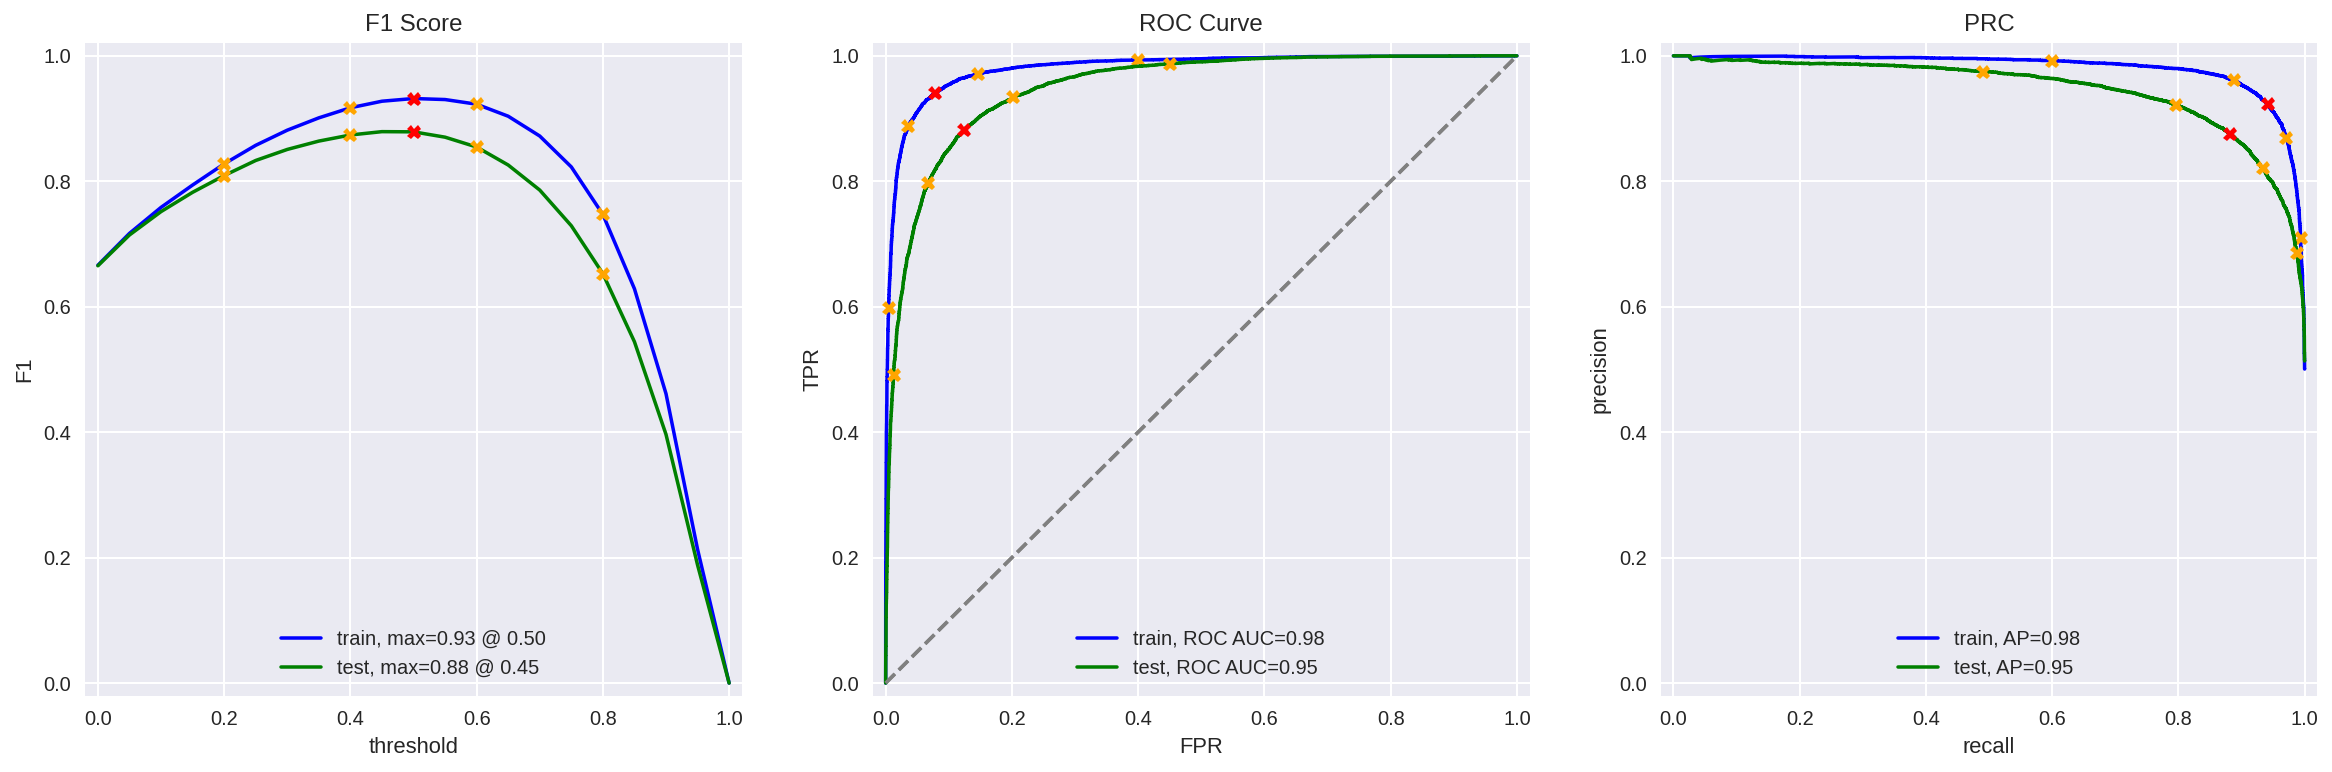

In [53]:
evaluate_model(model_3, corpus_train_3, train_target, corpus_test_3, test_target)

The results of F1 for spaCy, TF-IDF and LR are also good: 0.93 for train set and 0.88 for test set. But text preprocessing took a 10 min. For now NLTK, TF-IDF and LR showed better results.

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [10]:
from lightgbm import LGBMClassifier

In [54]:
model_4 = Pipeline(
    steps=[("tfidf", TfidfVectorizer(stop_words=stop_words)), 
           ("clf", LGBMClassifier(random_state = 123))])

param_grid = {
    "clf__learning_rate" : [0.1, 0.2, 0.3],
    "clf__n_estimators" : [150, 200],
    "clf__max_depth" : [10, 20]
}
grid4 = GridSearchCV(model_4, param_grid, cv=3, scoring = "f1")

grid4.fit(corpus_train_3, train_target)

print("Best params:")
print(grid4.best_params_)

print(f"Best F1 score: {abs(grid4.best_score_):.3f}")

Best params:
{'clf__learning_rate': 0.3, 'clf__max_depth': 20, 'clf__n_estimators': 200}
Best F1 score: 0.857


In [55]:
%%time
model_4 = Pipeline(
    steps=[("tfidf", TfidfVectorizer(stop_words=stop_words)), 
           ("clf", LGBMClassifier(learning_rate = 0.3, n_estimators = 200, 
                                  max_depth = 20, random_state = 123))]
)

model_4.fit(corpus_train_3, train_target)

CPU times: user 1min 58s, sys: 698 ms, total: 1min 58s
Wall time: 1min 59s


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('clf',
                 LGBMClassifier(learning_rate=0.3, max_depth=20,
                                n_estimators=200, random_state=123))])

          train  test
Accuracy    1.0  0.87
F1          1.0  0.87
APS         1.0  0.94
ROC AUC     1.0  0.94


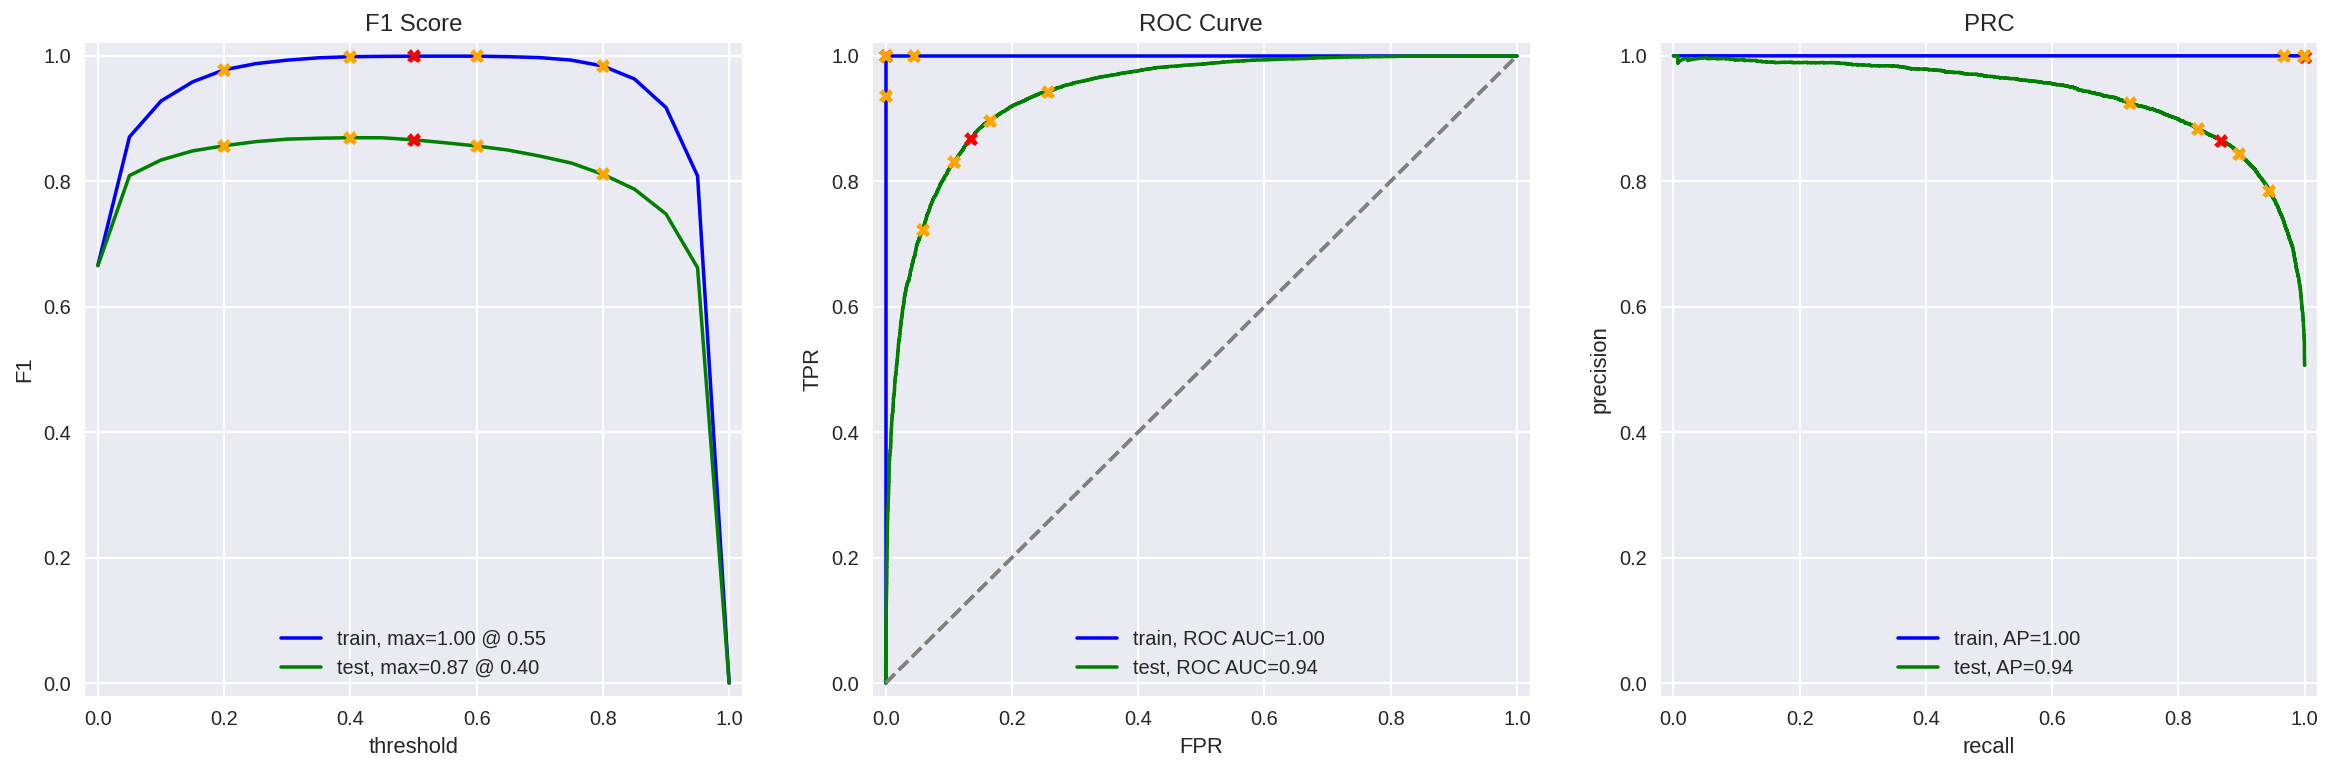

In [56]:
evaluate_model(model_4, corpus_train_3, train_target, corpus_test_3, test_target)

As we can see F! score for training set is 1 and for test set is 0.87 for the spaCy, TF-IDF and LGBMClassifier. The text preprocessing time is the same as for previous model. For now this model showed the best results

## My Reviews

In [57]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: " ".join(re.sub(r'[^a-zA-Z\']', ' ', x.lower()).split()))

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Model 2

In [73]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(texts.apply(lambda x: text_preprocessing_1(x)))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  i did not simply like it not my kind of movie
0.14:  well i was bored and felt asleep in the middle of the movie
0.46:  i was really fascinated with the movie
0.12:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.30:  i didn't expect the reboot to be so good writers really cared about the source material
0.53:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.87:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 3

In [74]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(texts.apply(lambda x: text_preprocessing_3(x)))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  i did not simply like it not my kind of movie
0.12:  well i was bored and felt asleep in the middle of the movie
0.49:  i was really fascinated with the movie
0.10:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.27:  i didn't expect the reboot to be so good writers really cared about the source material
0.50:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 4

In [75]:
texts = my_reviews['review_norm']
my_reviews_pred_prob = model_4.predict_proba(texts.apply(lambda x: text_preprocessing_3(x)))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.50:  i did not simply like it not my kind of movie
0.14:  well i was bored and felt asleep in the middle of the movie
0.58:  i was really fascinated with the movie
0.14:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.29:  i didn't expect the reboot to be so good writers really cared about the source material
0.86:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.10:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.96:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


## Conclusions

We had a dataset with reviews for different kind of movies and different years. After EDA we can see that with every year the amount of reviews is growing which connect with the worlwodening of internet, having more opportunities to share your oppinion and with grow of movie industry in general. So I tried to build a models for detecting bad reviews. As we can see above I used 3 types of models: NLTK, TD-IDF and LR, spaCy TD-IDF and LR and spaCy TD-IDF and LGBR. All of them showed up a good F1 score, which is higher then a threshold done 0.85. I wasn't able to check BERT, cause unfortunatelly my computer wasn't able to process it. On the final steps I was needed to check those models on my reviews. And here is an interesting thing. All models showed up the highest F1 score for the positive review. And the lowest one for negative. I think need to check this more deeply, maybe the wrong types of models have beed chosen.